In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms, utils
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy
%matplotlib inline

In [5]:
np.linalg.norm(np.ones((2,4,3)))

4.898979485566356

In [34]:
from pylab import rcParams

rcParams['figure.figsize'] = 15,15

In [35]:
raw_image = cv2.imread("sample1.png")[..., ::-1]
image = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        )
])(raw_image.copy()).unsqueeze(0)

In [36]:
image.shape

torch.Size([1, 3, 873, 1278])

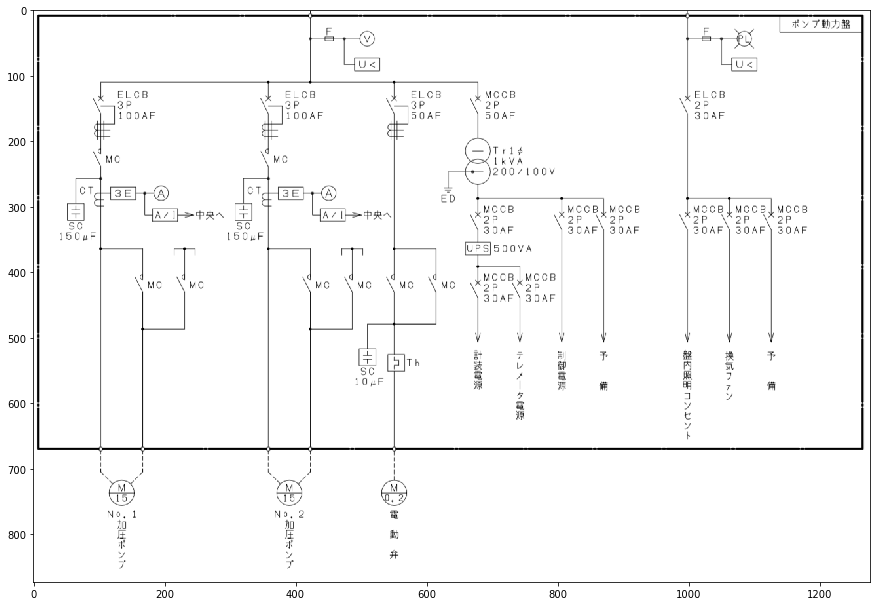

In [37]:
plt.imshow(raw_image)

In [38]:
#raw_template = raw_image[20:100, 570:650, :] #ostrich.jpg face
#raw_template = raw_image[100:170, 220:330, :] #sample.png, 3E
raw_template = raw_image[120:210, 85:130, :] #sample1.png ELCB
#raw_template = raw_image[265:295, 180:210, :]　#sample1.png A
#raw_template = raw_image[205:245, 85:110, :]
#raw_template = cv2.resize(raw_template, dsize=None, fx=1.3, fy=1.3)

In [39]:
raw_template.shape

(90, 45, 3)

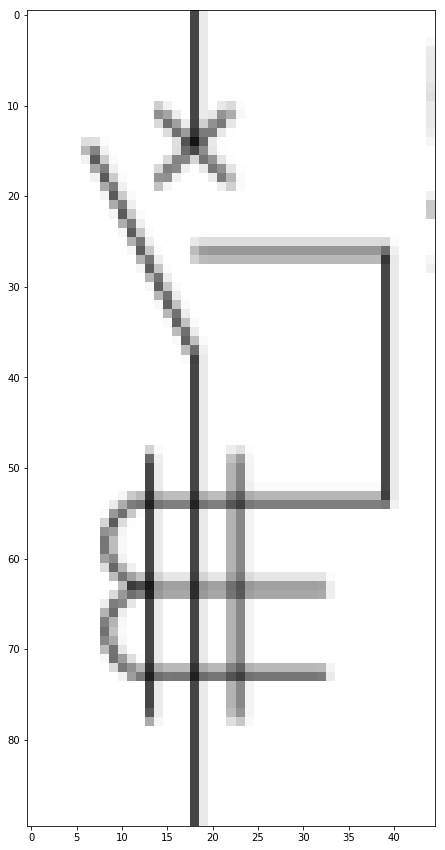

In [40]:
plt.imshow(raw_template)

In [41]:
template = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        )
])(raw_template.copy()).unsqueeze(0)

In [42]:
class FeatureExtractor():
    def __init__(self, model, use_cuda=True, padding=True):
        self.model = copy.deepcopy(model)
        self.use_cuda = use_cuda
        self.feature_maps = []
        
        if self.use_cuda:
            self.model = self.model.cuda()
            
        self.index = []
        self.f = []
        self.stride = []
        for i, module in enumerate(self.model.children()):
            if isinstance(module, nn.Conv2d):
                self.index.append(i)
                self.f.append(module.kernel_size[0])
                self.stride.append(module.stride[0])
            if isinstance(module, nn.MaxPool2d):
                if padding:
                    module.padding = 1
                self.index.append(i)
                self.f.append(module.kernel_size)
                self.stride.append(module.stride)
        
        self.rf = np.array(self.calc_rf(self.f, self.stride))
        
    def save_template_feature_map(self, module, input, output):
        self.template_feature_map = output.detach()
        
    def save_image_feature_map(self, module, input, output):
        self.image_feature_map = output.detach()
                
    def calc_rf(self, f, stride):
        rf = []
        for i in range(len(f)):
            if i == 0:
                rf.append(3)
            else:
                rf.append(rf[i-1] + (f[i]-1)*self.product(stride[:i]))
        return rf
    
    def product(self, lis):
        if len(lis) == 0:
            return 0
        else:
            res = 1
            for x in lis:
                res *= x
            return res
    
    def calc_l_star(self, template, k=3):
        l = np.sum(self.rf <= min(list(template.size()[-2:]))) - 1
        l_star = max(l - k, 1)
        return l_star
    
    def calc_NCC(self, F, M):
        h_f, w_f = F.shape[-2:]
        NCC = np.zeros((M.shape[-2] - h_f, M.shape[-1] - w_f))
        for i in range(M.shape[-2] - h_f):
            print(i)
            for j in range(M.shape[-1] - w_f):
                M_tilde = M[:,:, i:i+h_f, j:j+w_f]
                NCC[i, j] = np.sum((M_tilde * F)/(np.linalg.norm(M_tilde)*np.linalg.norm(F)))
        return NCC
                
        if self.use_cuda:
            NCC = NCC.cpu()
        return NCC.numpy()

    def __call__(self, template, image, threshold=None):
        if self.use_cuda:
            template = template.cuda()
            image = image.cuda()
            
        self.l_star = self.calc_l_star(template)
        
        print("save features...")
        
        # save template feature map (named F in paper)
        template_handle = self.model[self.index[self.l_star]].register_forward_hook(self.save_template_feature_map)
        self.model(template)
        template_handle.remove()
        
        # save image feature map (named M in papar)
        image_handle = self.model[self.index[self.l_star]].register_forward_hook(self.save_image_feature_map)
        self.model(image)
        image_handle.remove()
        
        if self.use_cuda:
            self.template_feature_map = self.template_feature_map.cpu()
            self.image_feature_map = self.image_feature_map.cpu()
            
        print("calc NCC...")
        # calc NCC
        #self.NCC = self.calc_NCC_tensor(self.template_feature_map, self.image_feature_map)
        self.NCC = self.calc_NCC(self.template_feature_map.numpy(), self.image_feature_map.numpy())
        if threshold is None:
            threshold = 0.95 * np.max(self.NCC)
        max_indices = np.array(np.where(self.NCC > threshold)).T
        print("length of boxes: {}".format(len(max_indices)))
        
        boxes = []
        centers = []
        scores = []
        for max_index in max_indices:
            i_star, j_star = max_index
            NCC_part = self.NCC[i_star-1:i_star+2, j_star-2:j_star+2]

            x_center = (j_star + self.template_feature_map.size()[-1]/2) * image.size()[-1] // self.image_feature_map.size()[-1]
            y_center = (i_star + self.template_feature_map.size()[-2]/2 )* image.size()[-2] // self.image_feature_map.size()[-2]

            x1_0 = x_center - template.size()[-1]/2
            x2_0 = x_center + template.size()[-1]/2
            y1_0 = y_center - template.size()[-2]/2
            y2_0 = y_center + template.size()[-2]/2

            stride_product = self.product(self.stride[:self.l_star])

            x1 = np.sum(NCC_part * (x1_0 + np.array([-2, -1, 0, 1]) *  stride_product)[None, :]) / np.sum(NCC_part)
            x2 = np.sum(NCC_part * (x2_0 + np.array([-2, -1, 0, 1]) *  stride_product)[None, :]) / np.sum(NCC_part)
            y1 = np.sum(NCC_part * (y1_0 + np.array([-1, 0, 1]) * stride_product)[:, None]) / np.sum(NCC_part)
            y2 = np.sum(NCC_part * (y2_0 + np.array([-1, 0, 1]) * stride_product)[:, None]) / np.sum(NCC_part)

            x1 = int(round(x1))
            x2 = int(round(x2))
            y1 = int(round(y1))
            y2 = int(round(y2))
            x_center = int(round(x_center))
            y_center = int(round(y_center))
            
            boxes.append([(x1, y1), (x2, y2)])
            centers.append((x_center, y_center))
            scores.append(np.sum(NCC_part))

        return boxes, centers, scores

In [43]:
def nms(dets, scores, thresh):
    x1 = dets[:, 0, 0]
    y1 = dets[:, 0, 1]
    x2 = dets[:, 1, 0]
    y2 = dets[:, 1, 1]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep

In [45]:
vgg_feature = models.vgg13(pretrained=True).features

In [46]:
FE = FeatureExtractor(vgg_feature, use_cuda=False, padding=True)

In [52]:
boxes, centers, scores = FE(template, image, threshold=None)

save features...
calc NCC...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81


KeyboardInterrupt: 

In [68]:
FE.template_feature_map.cpu().numpy()[0].shape

(128, 24, 12)

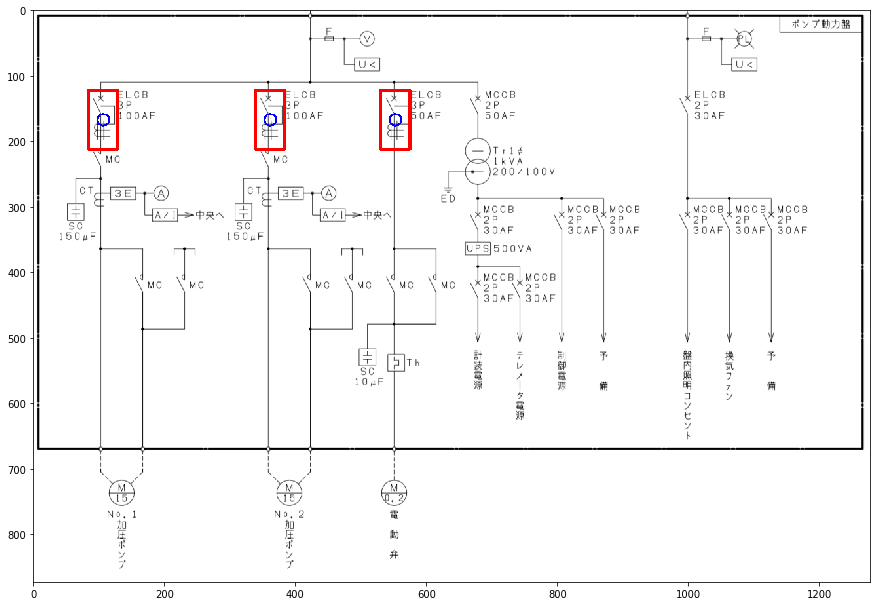

In [72]:
d_img = raw_image.astype(np.uint8).copy()
for i in nms(np.array(boxes), np.array(scores), thresh=0.5):
    d_img = cv2.rectangle(d_img, boxes[i][0], boxes[i][1], (255,0,0), 3)
    d_img = cv2.circle(d_img, centers[i], int((boxes[i][1][0] - boxes[i][0][0])*0.2), (0,0,255), 2)
plt.imshow(d_img)

In [73]:
FE.template_feature_map.cpu().numpy().shape

(1, 128, 24, 12)

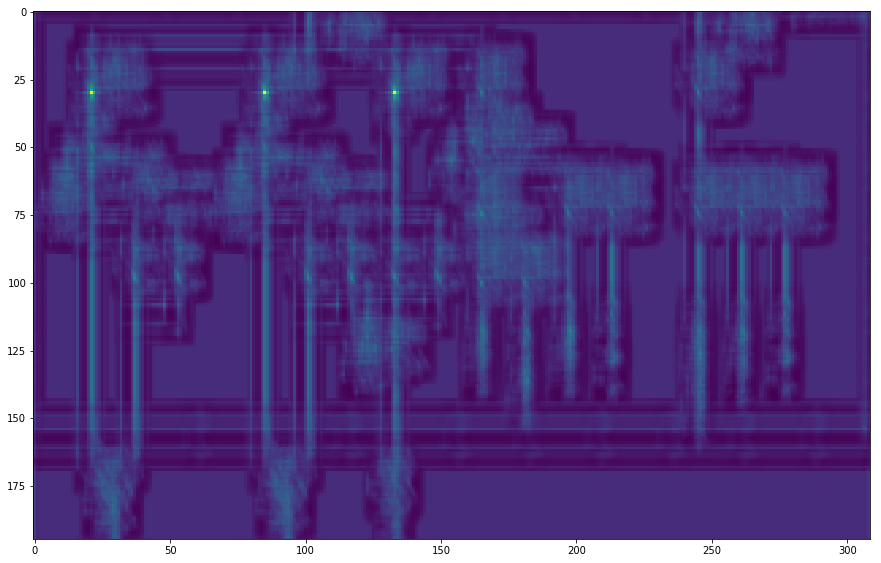

In [74]:
NCC = FE.NCC / np.max(FE.NCC)
plt.imshow(NCC)

In [60]:
a = np.random.randint( 0, 10, (2, 3,4))

In [61]:
a

array([[[2, 9, 2, 8],
        [1, 1, 1, 0],
        [3, 4, 5, 8]],

       [[5, 9, 1, 0],
        [3, 8, 0, 8],
        [1, 8, 9, 9]]])

In [62]:
a.flatten()

array([2, 9, 2, 8, 1, 1, 1, 0, 3, 4, 5, 8, 5, 9, 1, 0, 3, 8, 0, 8, 1, 8,
       9, 9])

In [64]:
b = np.zeros((2,3,4))
(size1, size2, size3) = a.shape
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        for k in range(a.shape[2]):
            b[i][j][k] = a.flatten()[i*size2*size3 + j*size3 + k]

In [67]:
np.sum(b -a)

0.0

In [70]:
F = FE.template_feature_map.cpu().numpy()[0].astype(np.float32)

In [71]:
M = FE.image_feature_map.cpu().numpy()[0].astype(np.float32)

In [72]:
import cython_calc_NCC

In [79]:
NCC_flat = np.zeros(F.shape[0] * (M.shape[1] - F.shape[1]) * (M.shape[2] - F.shape[2])).astype(np.double)

In [ ]:
cython_calc_NCC.c_calc_NCC(M.flatten().astype(np.double), np.array(M.shape).astype(np.int32), F.flatten().astype(np.double), np.array(F.shape).astype(np.int32), NCC_flat)

In [75]:
np.array(M.shape)

array([128, 219, 321])